# Imports

In [18]:
# System Imports
import os
import time

# Data Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import helper_functions as hf

# Deep Learning Framework
import tensorflow as tf

# SSL
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [19]:
for device in tf.config.list_physical_devices('GPU'):
    print(f"* {device}")

## Reading in Images

In [20]:
# Setting paths

train_data_path = './data/archive/train'
test_data_path = './data/archive/test'

In [21]:
# Viewing categories

categories = os.listdir(train_data_path)
print(f"The categories are: {categories}")

The categories are: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [22]:
# Configurations

SEED = 0
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.20
EPOCHS = 10

In [23]:
# Creating the training set

training_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=categories
)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.


In [24]:
# Creating the validation set

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=categories
)

Found 2746 files belonging to 5 classes.
Using 549 files for validation.


## Plotting Images

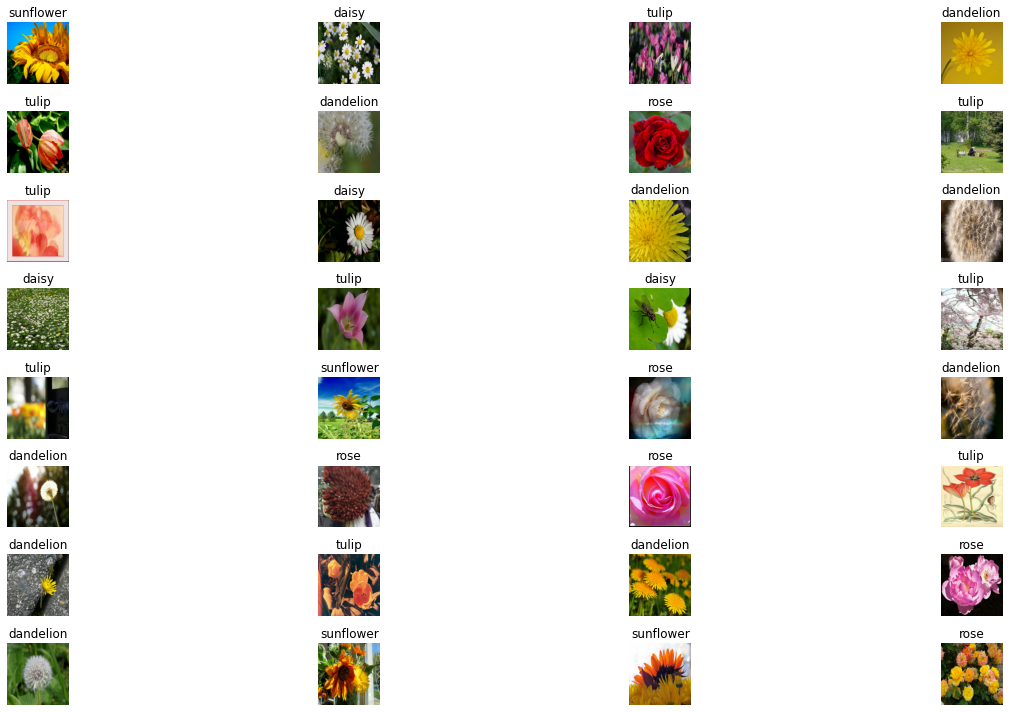

In [25]:
# Plotting some images

hf.plot_images(training_set, categories)

# Modeling

In [26]:
# Function that creates a model

def get_baseline_model(): 

    ## Clearing backend
    tf.keras.backend.clear_session()

    ## Input Layer
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Rescaling the images
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    ## First CNN
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Second CNN
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Third CNN
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Flatten layer
    x = tf.keras.layers.Flatten()(x)

    ## First Dense layer
    x = tf.keras.layers.Dense(
        units=64,
        activation='relu'
    )(x)

    ## Output
    outputs = tf.keras.layers.Dense(
        units=len(categories),
        activation='softmax'
    )(x)

    ## Creating Model
    model = tf.keras.Model(
        inputs=inputs,
        outputs=outputs
    )

    ## Compiling the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    ## Viewing the architecture
    model.summary()

    return model

In [27]:
model_elapsed_time = {}

In [28]:
# Training the model

start_time = time.time()

baseline_model = get_baseline_model()

history = baseline_model.fit(
  training_set,
  validation_data=validation_set,
  epochs=EPOCHS
)

elasped_time = time.time() - start_time
model_elapsed_time["baseline"] = elasped_time

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

KeyboardInterrupt: 

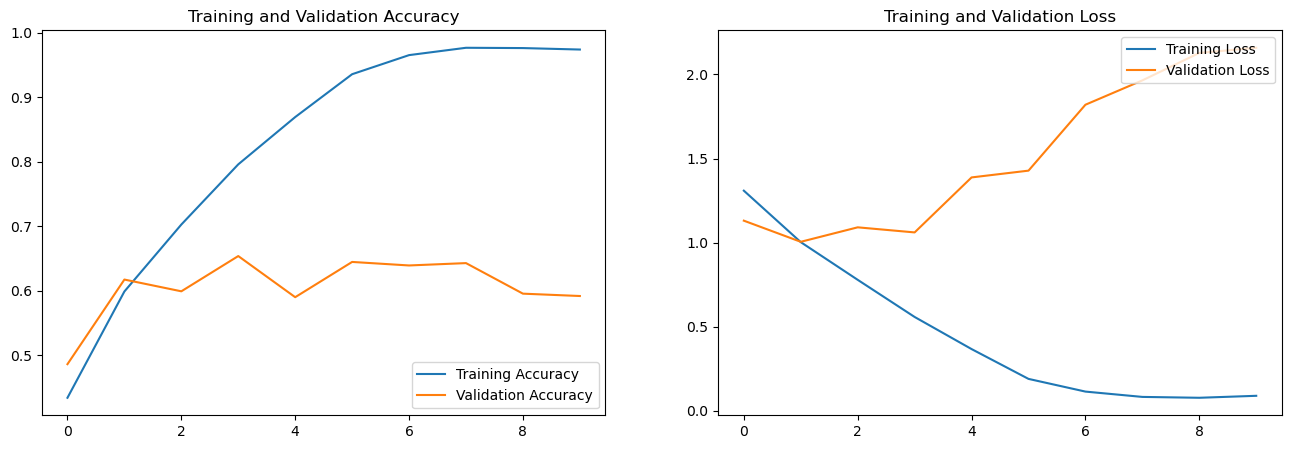

In [12]:
# Viewing the results of the training

hf.plot_history(history)

1/1 [==============================] - 0s 15ms/step


2022-12-11 15:01:11.040132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


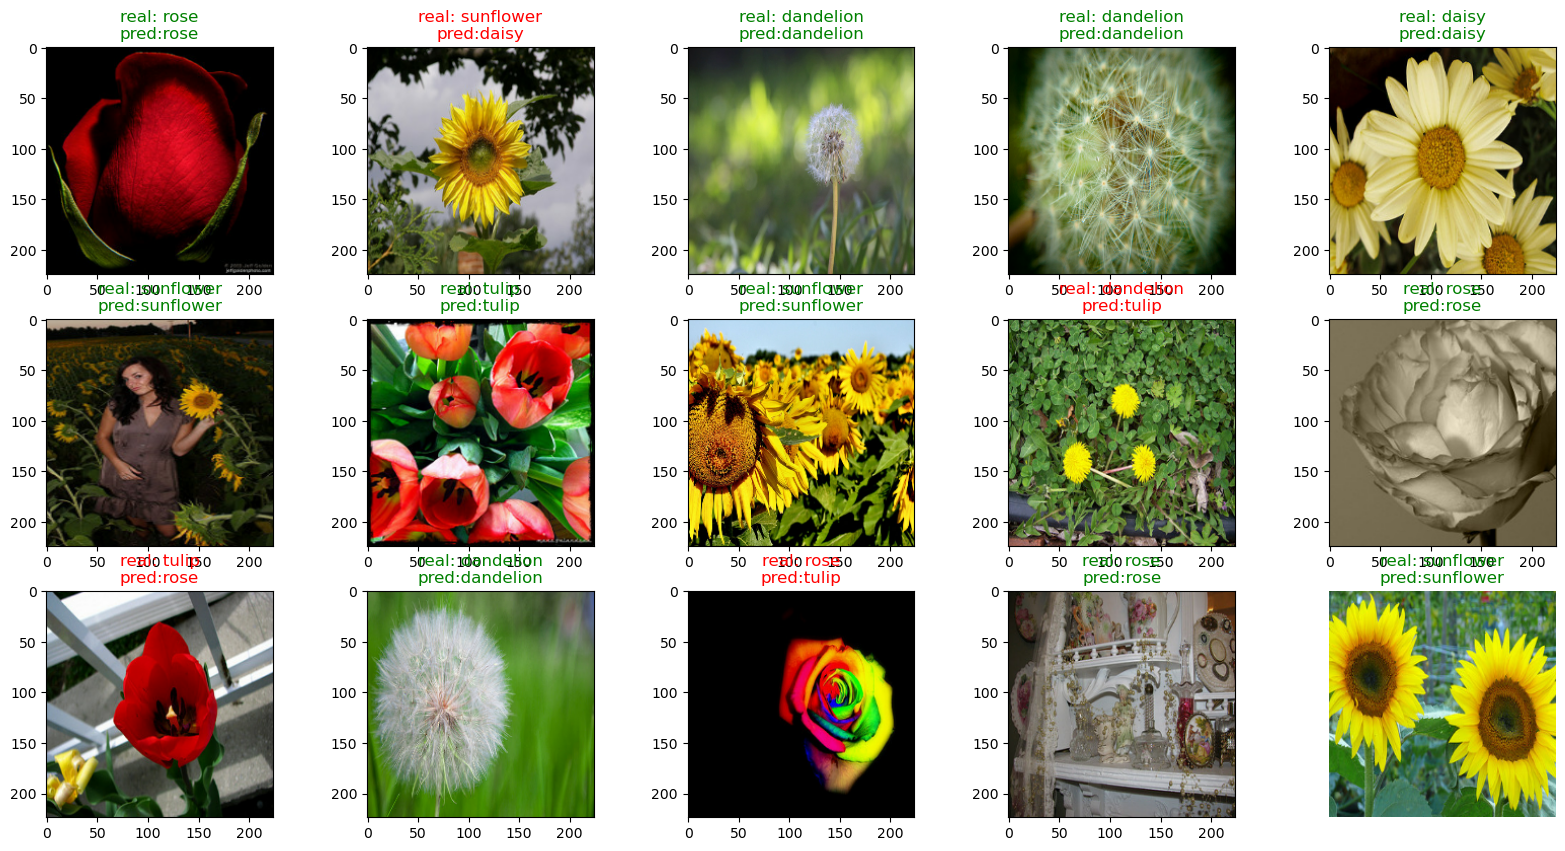

In [13]:
hf.plot_actual_prediction(baseline_model, categories, validation_set)

Model is not performing well. Accuracy is terrible (bias is high). And generalization is bad (variance is high). 

Since the model did not accurately predict the flowers, the model didn't learn key features that differentiates the flowers (categories).

Solutions:
<ul>
    <li> Data Augmentation </li>
         * Create new images by augmenting the images to expose the model to more images
    <li> Transfer Learning</li>
        * Use a working model that performs well for our task<br>
    <li> Get more data</li>
        * Find more data for the model
</ul>

## Data Augmentation

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[0]),
  tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(
      "horizontal_and_vertical", 
      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 3)
  ),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

def prepare(ds, shuffle=False, augment=False):
  
#     # Resize and rescale all datasets.
#     ds = ds.map(
#         lambda x, y: (resize_and_rescale(x), y), 
#         num_parallel_calls=AUTOTUNE
#     )
    
#     print()

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE
        )
    
#     # Batch all datasets.
#     ds = ds.batch(BATCH_SIZE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
train_ds = prepare(training_set, shuffle=True, augment=True)
val_ds = prepare(validation_set)

In [31]:
# Running the model

tf.keras.backend.clear_session()

start_time = time.time()

augment_model = get_baseline_model()

augment_history = augment_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)

elasped_time = time.time() - start_time
model_elapsed_time['data_augmentation'] = elasped_time

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

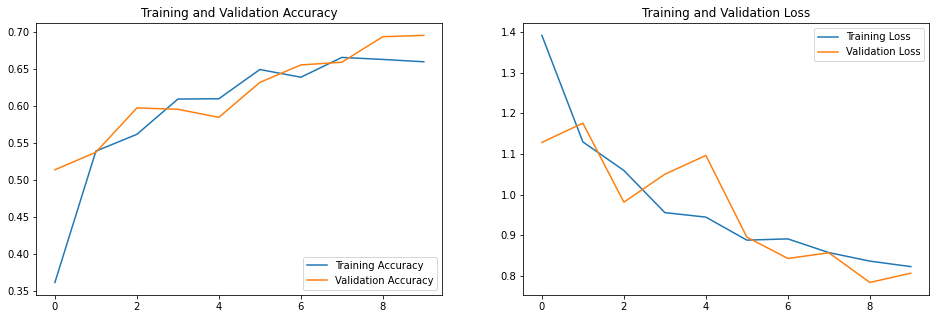

In [32]:
# Viewing the results of the training

hf.plot_history(augment_history)

In [48]:
augment_model.save('saved_model/augment_model.h5')

The training and validation have similar accuracy and loss (low variance). However the accuracy is ~70% (high bias). If we would like, we can do more augmentation like random contrasting.

Next we will try transfer learning. Use a model that has a great track record classifying and apply it to our task.

## Transfer Learning

In [34]:
base_transfer_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SIZE+ (3,),
    include_top=False,
    weights='imagenet'
)

In [35]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_transfer_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 576)


In [36]:
base_transfer_model.trainable = False

In [37]:
base_transfer_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [38]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [39]:
# prediction_layer = tf.keras.layers.Dense(len(categories), activation='softmax')
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [40]:
# IMG_RESIZE = 160

# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.Resizing(IMG_RESIZE, IMG_RESIZE),
#   tf.keras.layers.Rescaling(1./255)
# ])

# def prepare_transfer_learning_data(ds, shuffle=False):
#     ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
#               num_parallel_calls=AUTOTUNE)
#     return ds.prefetch(buffer_size=AUTOTUNE)

In [41]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_transfer_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(categories), activation='softmax')(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [42]:
start_time = time.time()

transfer_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

elasped_time = time.time() - start_time
model_elapsed_time['transfer_model'] = elasped_time

In [43]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2885      
                                                                 
Total params: 942,005
Trainable params: 2,885
Non-trainable params: 939,120
_________________________________________________________________


In [44]:
transfer_history = transfer_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)

Epoch 1/10
69/69 [==============================] - 12s 132ms/step - loss: 1.1883 - accuracy: 0.5576 - val_loss: 0.7736 - val_accuracy: 0.7377
Epoch 2/10
69/69 [==============================] - 10s 130ms/step - loss: 0.7123 - accuracy: 0.7506 - val_loss: 0.6012 - val_accuracy: 0.8051
Epoch 3/10
69/69 [==============================] - 10s 132ms/step - loss: 0.5852 - accuracy: 0.7997 - val_loss: 0.5189 - val_accuracy: 0.8579
Epoch 4/10
69/69 [==============================] - 9s 116ms/step - loss: 0.5172 - accuracy: 0.8302 - val_loss: 0.4758 - val_accuracy: 0.8689
Epoch 5/10
69/69 [==============================] - 9s 117ms/step - loss: 0.4797 - accuracy: 0.8343 - val_loss: 0.4536 - val_accuracy: 0.8761
Epoch 6/10
69/69 [==============================] - 9s 120ms/step - loss: 0.4440 - accuracy: 0.8507 - val_loss: 0.4400 - val_accuracy: 0.8798
Epoch 7/10
69/69 [==============================] - 9s 116ms/step - loss: 0.4246 - accuracy: 0.8484 - val_loss: 0.4252 - val_accuracy: 0.8743
Epo

In [47]:
# transfer_model.save('saved_model/transfer_model')
transfer_model.save('saved_model/transfer_model.h5')

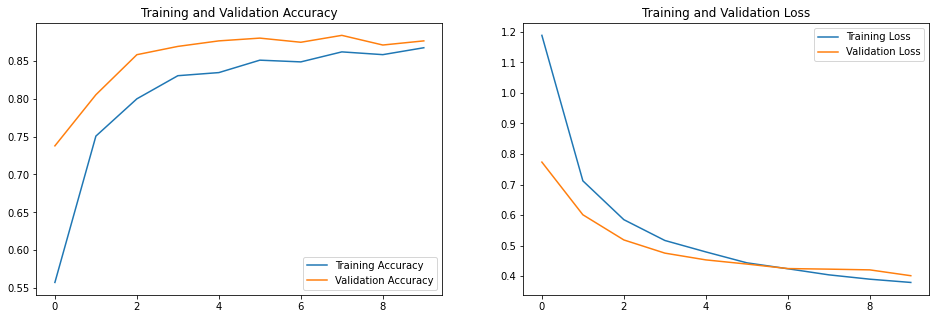

In [46]:
hf.plot_history(transfer_history)